<a href="https://colab.research.google.com/github/samuelkanneman/GoogleColab_Kanneman/blob/main/Proc_Habla_RN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importar Librerias

In [37]:
!pip install nltk
!pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 5.6 MB/s eta 0:00:00


In [51]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import re
from imblearn.under_sampling import RandomUnderSampler
from nltk.stem import WordNetLemmatizer
from unidecode import unidecode
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Cargar Documento

In [40]:
import os

# Definir la ruta del archivo PDF en Google Drive
libro = '/content/drive/MyDrive/Colab Notebooks/24 horas en la vida de una mujer.txt'

# Verificar si la ruta existe
if os.path.exists(libro):
    print("El archivo existe y la ruta es correcta.")
else:
    print("El archivo no existe o la ruta es incorrecta.")

El archivo existe y la ruta es correcta.


#Limpieza de texto

In [41]:
# Función de limpieza de texto
def limpiar_texto(texto):
    texto = texto.lower()  # Convertir a minúsculas
    texto = re.sub(r'\W', ' ', texto)  # Eliminar caracteres especiales
    texto = re.sub(r'\s+', ' ', texto)  # Eliminar espacios extra
    return texto

In [42]:
# Función para lematizar texto
def lematizar_texto(tokens):
    lemmatizer = WordNetLemmatizer()
    tokens_lemmatizados = [lemmatizer.lemmatize(token) for token in tokens]
    return tokens_lemmatizados

In [44]:
# Leer y limpiar el texto
with open(libro, 'r') as f:
    texto = f.read()

In [45]:
texto_limpio = limpiar_texto(texto)

# Tokenización
tokens = nltk.word_tokenize(texto_limpio)

In [46]:
print('Cantidad de tokens unicos',len(tokens))

Cantidad de tokens unicos 22637


Fraccion de Stopwords en un corpus

In [47]:
def stopwords_percentage(text):
  '''
  aqui usamos un recurso léxico (stopwords) para filtrar un corpus
  '''
  stopwd = stopwords.words('spanish')
  content = [w  for w in text if w.lower() not in stopwd]
  return len(content)/len(text)

stopwords_percentage(tokens)

0.5240535406635155

Limpieza de texto

In [48]:
# Eliminar stopwords
stop_words = set(stopwords.words('spanish'))
tokens_filtrados = [token for token in tokens if token not in stop_words]

In [49]:
print('Cantidad de tokens sin stopwords',len(tokens_filtrados))

Cantidad de tokens sin stopwords 11863


Lematización

In [50]:
tokens_lemmatizados = lematizar_texto(tokens_filtrados)

print('Cantidad de tokens únicos después de lematización:', len(set(tokens_lemmatizados)))

Cantidad de tokens únicos después de lematización: 4933


#Vectorizacion

Conjunto de Etiquetas

In [52]:
etiquetas_sentimiento = {
    'bueno': 1,
    'feliz': 1,
    'contento':1,
    'amable':1,
    'alegre': 1,
    'satisfecho': 1,
    'irritado':0,
    'mal': 0,
    'triste': 0,
    'malo':0,
    'enojado':0,
    'furioso': 0,
    'descontento': 0
}

# Filtrar tokens y crear etiquetas
tokens_filtrados_etiquetados = [(token, etiquetas_sentimiento[token]) for token in tokens_lemmatizados if token in etiquetas_sentimiento]

# Separar tokens y etiquetas
tokens_finales, y = zip(*tokens_filtrados_etiquetados)
tokens_finales = list(tokens_finales)
y = np.array(y)

In [53]:
# Vectorización TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(tokens_finales)

print('Tamaño de la matriz TF-IDF:', X.shape)

Tamaño de la matriz TF-IDF: (11, 6)


#Construcción del Modelo de Red Neuronal

Dividir los datos en conjuntos de entrenamiento y prueba

In [54]:
# División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Normalizacion

In [56]:
from sklearn.preprocessing import MaxAbsScaler
# Normalización de los datos de entrada
scaler = MaxAbsScaler()
X_train_normalized = scaler.fit_transform(X_train.toarray())
X_test_normalized = scaler.transform(X_test.toarray())

Aquitectura del modelo

In [57]:
# Definir la arquitectura del modelo
model = Sequential()
model.add(Dense(128, input_shape=(X_train_normalized.shape[1],), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Usar 'sigmoid' para clasificación binaria

# Compilar el modelo con la función de pérdida binary_crossentropy
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Resumen del modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               896       
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 9217 (36.00 KB)
Trainable params: 9217 (36.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#Entrenamiento y Evaluación

Entranamiento

In [58]:
# Entrenar el modelo con un tamaño de batch más grande y más épocas
history = model.fit(X_train_normalized, y_train, epochs=50, batch_size=128, validation_split=0.2)

# Evaluar el modelo
loss, accuracy = model.evaluate(X_test_normalized, y_test)
print('Accuracy:', accuracy)

Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 0.6379 - accuracy: 0.6667 - val_loss: 0.6808 - val_accuracy: 0.5000
Epoch 2/50
1/1 [==============================] - 0s 73ms/step - loss: 0.6153 - accuracy: 1.0000 - val_loss: 0.6798 - val_accuracy: 0.5000
Epoch 3/50
1/1 [==============================] - 0s 63ms/step - loss: 0.5936 - accuracy: 1.0000 - val_loss: 0.6805 - val_accuracy: 0.5000
Epoch 4/50
1/1 [==============================] - 0s 80ms/step - loss: 0.5728 - accuracy: 1.0000 - val_loss: 0.6817 - val_accuracy: 0.5000
Epoch 5/50
1/1 [==============================] - 0s 74ms/step - loss: 0.5520 - accuracy: 1.0000 - val_loss: 0.6827 - val_accuracy: 0.5000
Epoch 6/50
1/1 [==============================] - 0s 72ms/step - loss: 0.5321 - accuracy: 1.0000 - val_loss: 0.6845 - val_accuracy: 0.5000
Epoch 7/50
1/1 [==============================] - 0s 84ms/step - loss: 0.5127 - accuracy: 1.0000 - val_loss: 0.6867 - val_accuracy: 0.5000
Epoch 8/50
1/1 [=============

Matiz de Confusion

In [59]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Realizar predicciones
y_pred = model.predict(X_test_normalized)

# Convertir las predicciones a etiquetas binarias
y_pred_binary = (y_pred > 0.5).astype(int)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Mostrar la matriz de confusión
print("Matriz de Confusión:")
print(conf_matrix)

1/1 [==============================] - 0s 106ms/step
Matriz de Confusión:
[[0 1]
 [0 2]]


Curva ROC

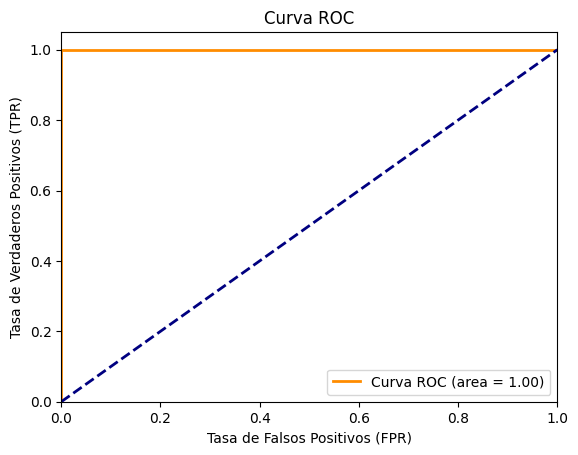

In [60]:
# Calcular la tasa de verdaderos positivos (TPR) y la tasa de falsos positivos (FPR) para la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

#Revisión del Rendimiento del Modelo

Ajuste de Hiperparámetros

In [61]:
from keras.layers import Dropout

# Definir la arquitectura del modelo con Dropout
model = Sequential()
model.add(Dense(128, input_shape=(X_train_normalized.shape[1],), activation='relu'))
model.add(Dropout(0.5))  # Añadir Dropout con probabilidad de 0.5
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))  # Añadir otro Dropout
model.add(Dense(1, activation='sigmoid'))  # Usar 'sigmoid' para clasificación binaria


In [63]:
# Compilar el modelo con una tasa de aprendizaje menor
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.0001)  # Reducir la tasa de aprendizaje
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
# Resumen del modelo
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               896       
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 9217 (36.00 KB)
Trainable params: 9217 (36.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Entrenar y evaluar con las modificaciones

In [64]:
# Entrenar el modelo con más épocas
history = model.fit(X_train_normalized, y_train, epochs=100, batch_size=128, validation_split=0.2)

# Evaluar el modelo
loss, accuracy = model.evaluate(X_test_normalized, y_test)
print('Accuracy:', accuracy)


Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 0.7809 - accuracy: 0.3333 - val_loss: 0.7289 - val_accuracy: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 0s 43ms/step - loss: 0.7768 - accuracy: 0.1667 - val_loss: 0.7288 - val_accuracy: 0.0000e+00
Epoch 3/100
1/1 [==============================] - 0s 40ms/step - loss: 0.7903 - accuracy: 0.0000e+00 - val_loss: 0.7288 - val_accuracy: 0.0000e+00
Epoch 4/100
1/1 [==============================] - 0s 58ms/step - loss: 0.7306 - accuracy: 0.3333 - val_loss: 0.7289 - val_accuracy: 0.0000e+00
Epoch 5/100
1/1 [==============================] - 0s 53ms/step - loss: 0.8434 - accuracy: 0.0000e+00 - val_loss: 0.7289 - val_accuracy: 0.0000e+00
Epoch 6/100
1/1 [==============================] - 0s 56ms/step - loss: 0.7362 - accuracy: 0.1667 - val_loss: 0.7291 - val_accuracy: 0.0000e+00
Epoch 7/100
1/1 [==============================] - 0s 39ms/step - loss: 0.7075 - accuracy: 0.5000 - val_loss: 0.7291 - val_accurac

Matriz de Confusion

In [65]:
# Realizar predicciones
y_pred = model.predict(X_test_normalized)

# Convertir las predicciones a etiquetas binarias
y_pred_binary = (y_pred > 0.5).astype(int)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Mostrar la matriz de confusión
print("Matriz de Confusión:")
print(conf_matrix)

1/1 [==============================] - 0s 68ms/step
Matriz de Confusión:
[[0 1]
 [0 2]]


Nueva curva ROC

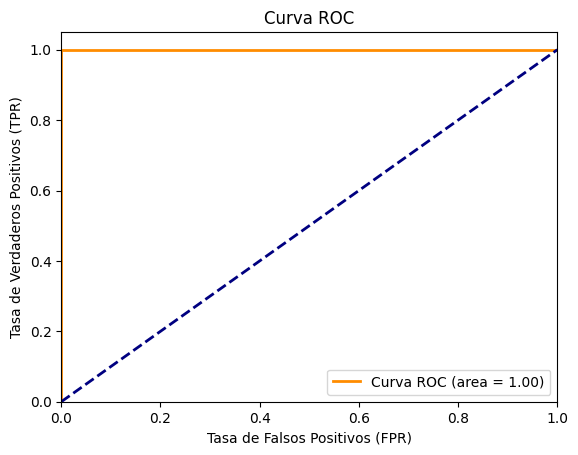

In [66]:
# Calcular la tasa de verdaderos positivos (TPR) y la tasa de falsos positivos (FPR) para la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()